In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')
import pickle
from numpy.linalg import eigvals, eig
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def f_deltar(deltar, delta, g):
    return delta * np.exp(-2 * np.sum((-g / (np.sqrt(N) * (deltar + w))) ** 2))

def f_f(deltar, g):
    return -g / (np.sqrt(N) * (deltar + w))

def f_energy(deltar, g):
    f = f_f(deltar, g)
    return -0.5 * deltar + np.sum(f * (w * f + 2 * g / np.sqrt(N)))

def f_fn(f):
    return np.array([np.sum(f * np.exp(-2 * 1j * np.pi * ks * (n - N / 2) / N)) / np.sqrt(N) for n in range(N)])

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)
        
import scipy.sparse as sparse
import scipy.sparse.linalg
import numpy as np

class PolaronDecay:
    def __init__(self, g, Delta = 1):
        self.g = g
        self.Delta = Delta
        self.DeltaR = analisis[self.Delta][self.g]
        self.fk = f_f(self.DeltaR, self.g)
        self.L = L = self.fk.size
        self.i2 = i2 = sparse.eye(2)
        self.iL = iL = sparse.eye(L + 1)
        
        # Qubit operators
        sx = sparse.coo_matrix([[0,1], [1,0]])
        sz = sparse.coo_matrix([[1,0], [0,-1]])
        Hqubit = self.DeltaR * sz / 2.0
        self.sx = sparse.kron(sx, self.iL)
        self.sz = sparse.kron(sz, self.iL)
        
        # Photon operators
        fA = np.zeros((L+1,L+1))
        fA[0,1:] = -self.fk #con menos porque las fk estan calculadas en un notebook que utiliza el otro convenio de signos
        fA = sparse.coo_matrix(fA)
        Hphotons = sparse.diags([0]+[w[i] for i in range(0,L)],
                                offsets=0, shape=(L+1,L+1))
        
        Vlocal = -2.0 * self.DeltaR * sparse.kron(sz, fA.T @ fA)
        self.H = (sparse.kron(Hqubit,iL) + Vlocal +
                  sparse.kron(i2, Hphotons) +
                  sparse.kron(2.0 * self.DeltaR * sx, fA + fA.T))

        # Value of Sz once we undo the polaron transformation
        self.szlab= (self.DeltaR/Delta * self.sz +
                     2 * self.DeltaR/Delta * sparse.kron(sx @ sz, fA.T - fA) -
                     4 * self.DeltaR/Delta * sparse.kron(sz, fA.T @ fA))
    
        # Empty state
        self.psi0 = np.zeros((2*(L+1),))
        self.psi0[L + 1] = 1.0
        
        
    '''
    def Hamiltonian(self):
            return self.H
    '''
    
    def evolve(self, t, nsteps=100):
        if not isinstance(t,np.ndarray):
            t = np.linspace(0, t, nsteps)
        psi = self.sx @ self.psi0
        
        dt = t[1] - t[0]
        output = np.zeros((t.size,2),dtype = np.float64)
        for i,_ in enumerate(t):
            if i:
                #psi = lanczos.expm(self.H, psi, dt=dt, tol=1e-12)
                psi = scipy.sparse.linalg.expm_multiply((-1j * dt) * self.H, psi)
                
            output[i,:] = [np.vdot(psi, self.sz @ psi).real,
                           np.vdot(psi, self.szlab @ psi).real]
        return  output, t, psi
    
    def spectrum(self, psi):
        return np.abs(psi[1:(self.L + 1)] ** 2) + np.abs(psi[self.L + 2:] ** 2)
    
    def overlap(self):
        return np.abs(eigen_eff[self.Delta][self.g].vects[0, 0]) ** 2
    
    def overlap_lab(self):
        new_v = np.append(eigen_eff[self.Delta][self.g].vects[0, 0], np.zeros(self.L + 1))
        new_v = np.append(new_v, eigen_eff[self.Delta][self.g].vects[1:, 0])
        
        return (np.conjugate(new_v).T @ self.szlab @ new_v).real
    
    def overlap_pol(self):
        new_v = np.append(eigen_eff[self.Delta][self.g].vects[0, 0], np.zeros(self.L + 1))
        new_v = np.append(new_v, eigen_eff[self.Delta][self.g].vects[1:, 0])
        
        return (np.conjugate(new_v).T @ self.sz @ new_v).real

In [2]:
w0 = 1.0
J = 0.4
N = 100
deltas = np.arange(0.1, 1.9, 0.1)
gs = np.arange(0.0, 1.21, 0.01)
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

In [3]:
f = open('analisis/analisis.pk', 'rb')
analisis = pickle.load(f)
f.close()

In [4]:
f = open('analisis/eigenanalisis.pk', 'rb')
aux = pickle.load(f)
eigen_eff = aux[0]
eigen_rwa = aux[1]
f.close()

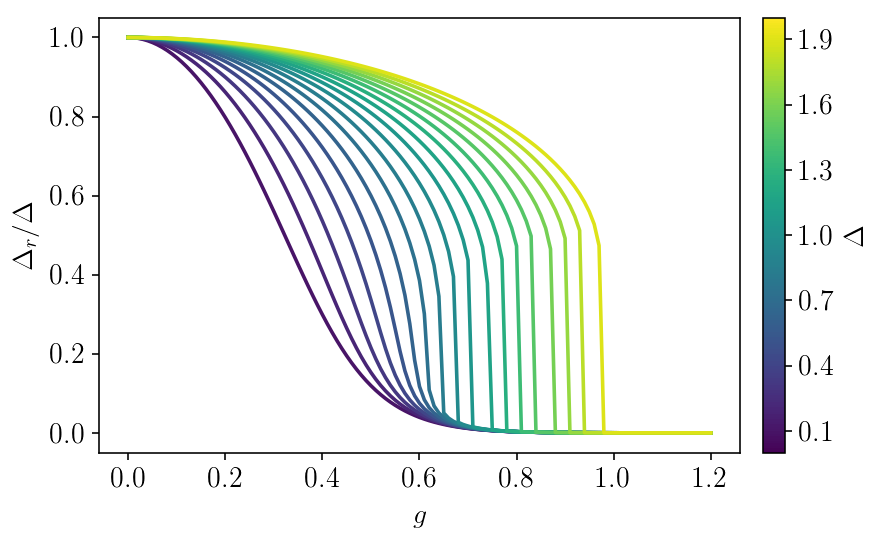

In [5]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

for delta in analisis.keys():
    plt.plot([g for g in analisis[delta].keys()], [deltar / delta for deltar in analisis[delta].values()])
    
plt.ylabel(r'$\Delta_r/\Delta$')
plt.xlabel(r'$g$')

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_delta_renorm.pdf', bbox_inches = 'tight')
plt.show()

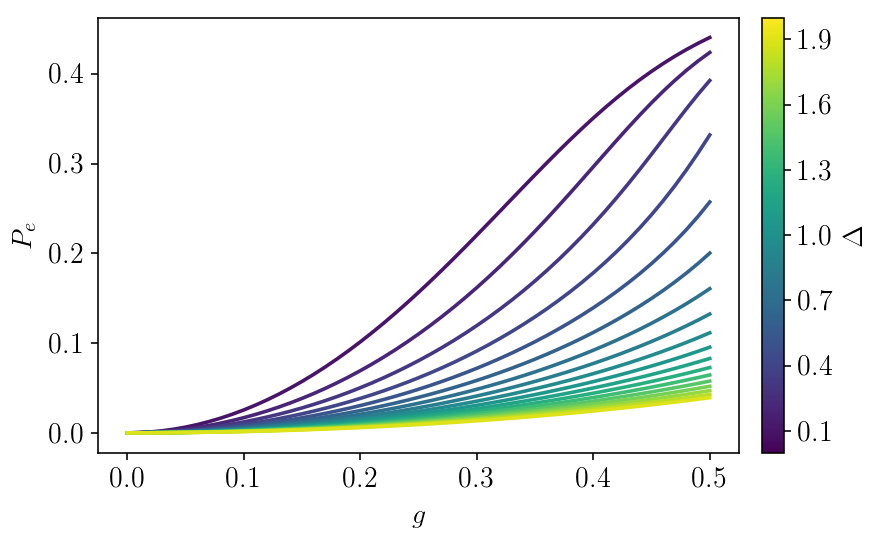

In [6]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

for delta in analisis.keys():
    plt.plot([g for g in analisis[delta].keys() if g <= 0.5], [(1 - deltar / delta) / 2 for g, deltar in analisis[delta].items() if g <= 0.5])
    
plt.ylabel(r'$P_e$')
plt.xlabel(r'$g$')

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_prob_excited.pdf', bbox_inches = 'tight')
plt.show()

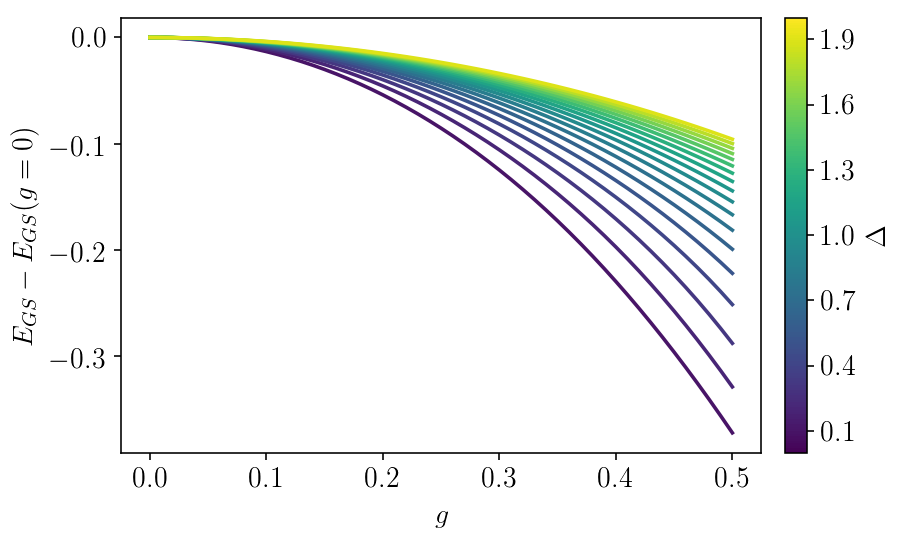

In [7]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

for delta in analisis.keys():
    plt.plot([g for g in analisis[delta].keys() if g <= 0.5], [f_energy(deltar, g) + delta / 2 for g, deltar in analisis[delta].items() if g <= 0.5])
    
plt.ylabel(r'$E_{GS} - E_{GS}(g = 0)$')
plt.xlabel(r'$g$')

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_gs_energy.pdf', bbox_inches = 'tight')
plt.show()

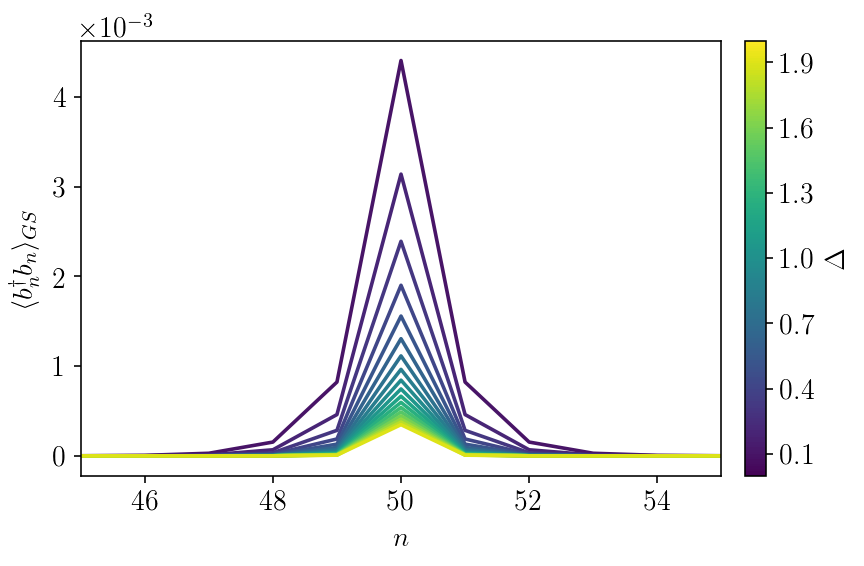

In [8]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

g = 0.05

for delta in analisis.keys():
    f = f_f(analisis[delta][g], g)
    fn = f_fn(f)
    
    plt.plot([n for n in range(N)], np.abs(fn) ** 2)

plt.ylabel(r'$\langle b_n^\dagger b_n \rangle_{GS}$')
plt.xlabel(r'$n$')
d = 5
plt.xlim(N // 2 - d, N // 2 + d)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_nphotons_g=005.pdf', bbox_inches = 'tight')
plt.show()

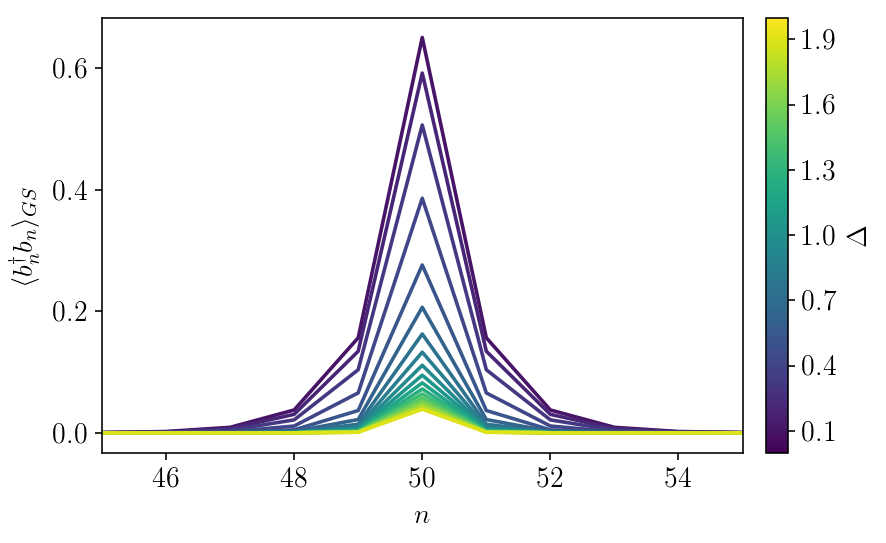

In [9]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

g = 0.5

for delta in analisis.keys():
    f = f_f(analisis[delta][g], g)
    fn = f_fn(f)
    
    plt.plot([n for n in range(N)], np.abs(fn) ** 2)

plt.ylabel(r'$\langle b_n^\dagger b_n \rangle_{GS}$')
plt.xlabel(r'$n$')
d = 5
plt.xlim(N // 2 - d, N // 2 + d)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_nphotons_g=05.pdf', bbox_inches = 'tight')
plt.show()

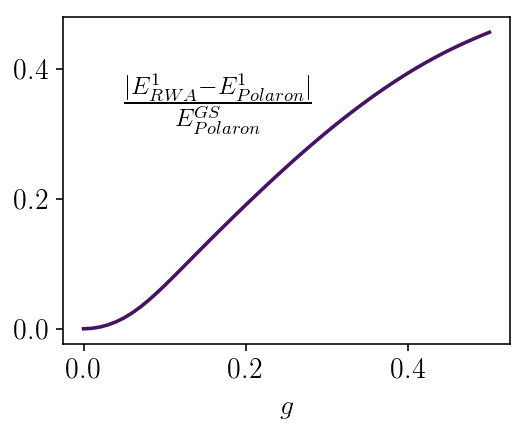

In [10]:
plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14

palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

bound_eff = []
bound_rwa = []
GS = []

delta = 0.3

gen = [g for g in analisis[delta].keys() if g <= 0.5]

for g in gen:
    vals_eff = eigen_eff[delta][g].vals
    vals_rwa = eigen_rwa[delta][g].vals
    
    f = f_f(analisis[delta][g], g)
    bound_eff.append((g, min(vals_eff) + np.sum(f * (w * f + 2 * g / np.sqrt(N)))))
    bound_rwa.append((g, min(vals_rwa)))
    GS.append((g, f_energy(analisis[delta][g], g)))

plt.plot([val[0] for val in bound_eff], [-(E_rwa[1] - E_eff[1]) / E_GS[1] for E_eff, E_rwa, E_GS in zip(bound_eff, bound_rwa, GS)], c = c1)

plt.text(0.05, 0.3, r'$\frac{|E^1_{RWA} - E^1_{Polaron}|}{E^{GS}_{Polaron}}$', size = 18)
#plt.ylabel(r'$E$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(r'$g$')
#plt.legend(frameon = False)

plt.savefig('figures/1q_rwa_vs_polaron_delta=03.pdf', bbox_inches = 'tight')
plt.show()

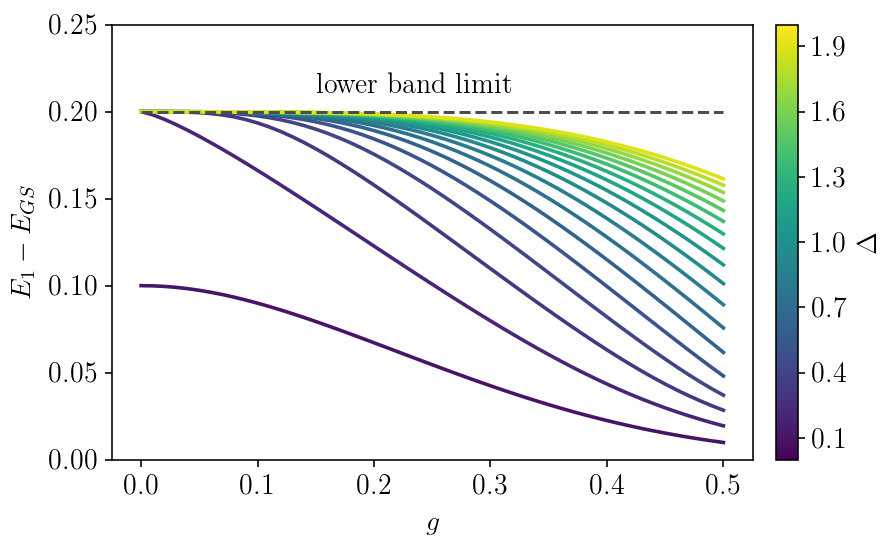

In [11]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

gen = [g for g in analisis[delta].keys() if g <= 0.5]

for delta in analisis.keys():
    bound_eff = []
    bound_rwa = []
    GS = []
    
    for g in gen:
        vals_eff = eigen_eff[delta][g].vals

        f = f_f(analisis[delta][g], g)
        bound_eff.append((g, min(vals_eff) + np.sum(f * (w * f + 2 * g / np.sqrt(N))) - f_energy(analisis[delta][g], g)))
        #GS.append((g, f_energy(analisis[delta][g], g)))
    
    plt.plot([val[0] for val in bound_eff], [E_eff[1] for E_eff in bound_eff])

plt.plot([val[0] for val in bound_eff], [w0 - 2 * J for val in bound_eff], c = (0.3, 0.3, 0.3), ls = 'dashed', lw = 1.5)
    
plt.ylabel(r'$E_1 - E_{GS}$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(r'$g$')
plt.ylim(0, 0.25)
plt.text(0.15, 0.21, 'lower band limit', color = 'black')

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_condition_for_existence.pdf', bbox_inches = 'tight')
plt.show()

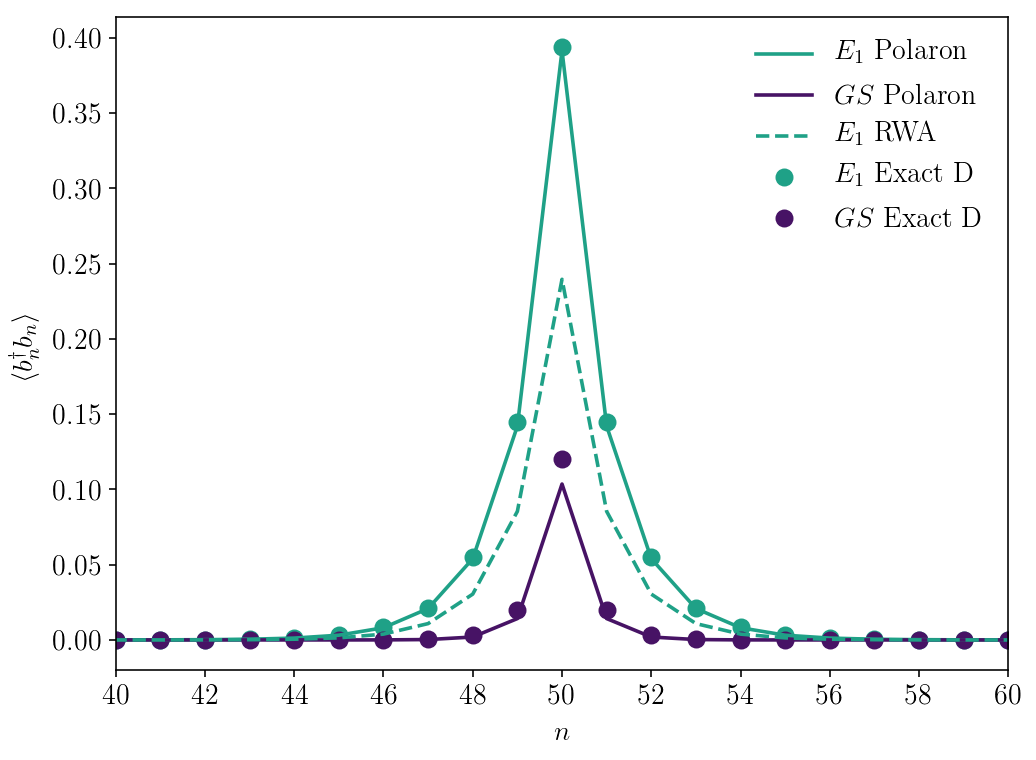

In [12]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis)))

palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.3

vals_eff = eigen_eff[delta][g].vals
vects_eff = eigen_eff[delta][g].vects
vals_rwa = eigen_rwa[delta][g].vals
vects_rwa = eigen_rwa[delta][g].vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])
vn_rwa = f_fn(vk_rwa[1:])

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)

plt.plot([n for n in range(N)], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

file_3 = 'data_files/number_GS_E1_E2_g=0,30_Delta=0,30.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 25, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3], [val[2] for val in data_3], label = r'$E_1$' + ' Exact D', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3], [val[1] for val in data_3], label = r'$GS$' + ' Exact D', marker='o', c = c1, zorder = 0, lw=0, markersize=8)

plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
plt.xticks(np.arange(40, 62, 2))
plt.legend(loc = 'upper right', frameon = False)

plt.savefig('figures/1q_bound_nphotons.pdf', bbox_inches = 'tight')
plt.show()

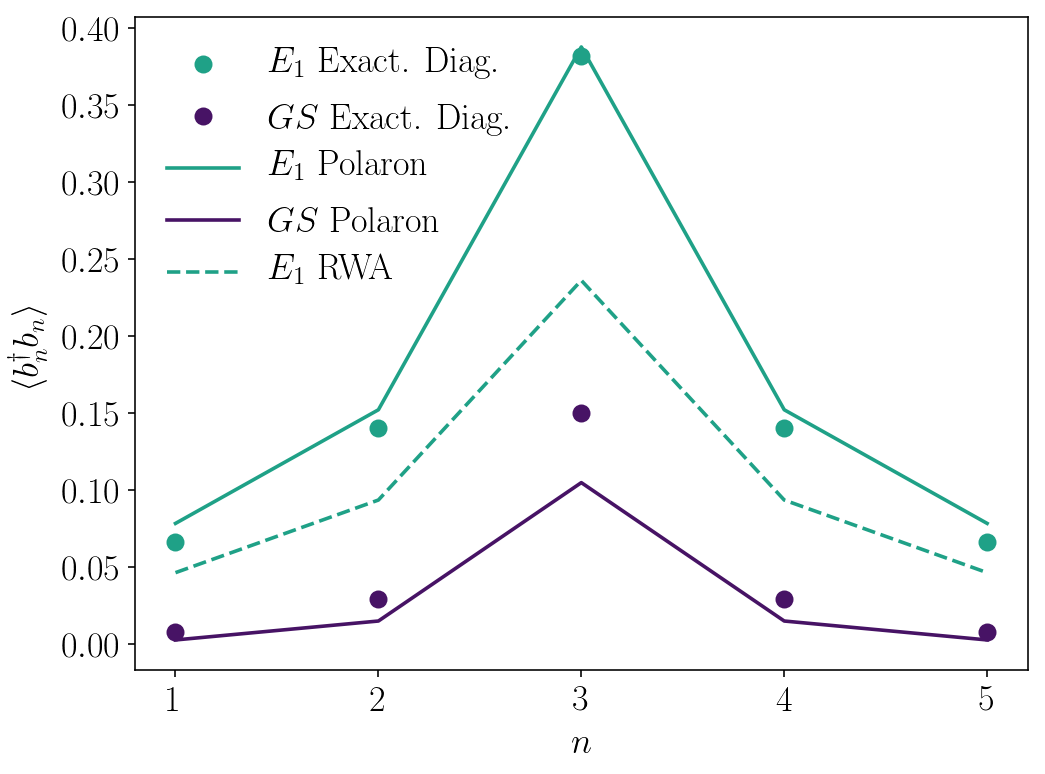

In [13]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 18
sns.set_palette(sns.color_palette("viridis", len(analisis)))

def eff_hamiltonian(deltar, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = deltar / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - deltar / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    f = f_f(deltar, g)
    for k in range(N):
        h3[k + 1, 0] = -2 * deltar * f[k]
        h3[0, k + 1] = -2 * deltar * f[k]
        
    h4 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        for p in range(N):
            h4[p + 1, k + 1] = 2 * deltar * f[k] * f[p]
    
    return h1 + h2 + h3 + h4

def rwa_hamiltonian(delta, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = delta / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - delta / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h3[k + 1, 0] = g / np.sqrt(N)
        h3[0, k + 1] = g / np.sqrt(N)
    
    return h1 + h2 + h3

def sorted_eigsystem(H):
    vals, vects = eig(H)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:,idx]
    
    return Eigensystem(vals, vects)

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)


palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.3
N = 6
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

file_3 = 'data_files/exact_6_5_0,3_0,3.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 3, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)



plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)


#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
plt.xticks(np.arange(1, 6))
plt.legend(loc = 'upper left', frameon = False)

plt.savefig('figures/1q_exact_02.pdf', bbox_inches = 'tight')
plt.show()

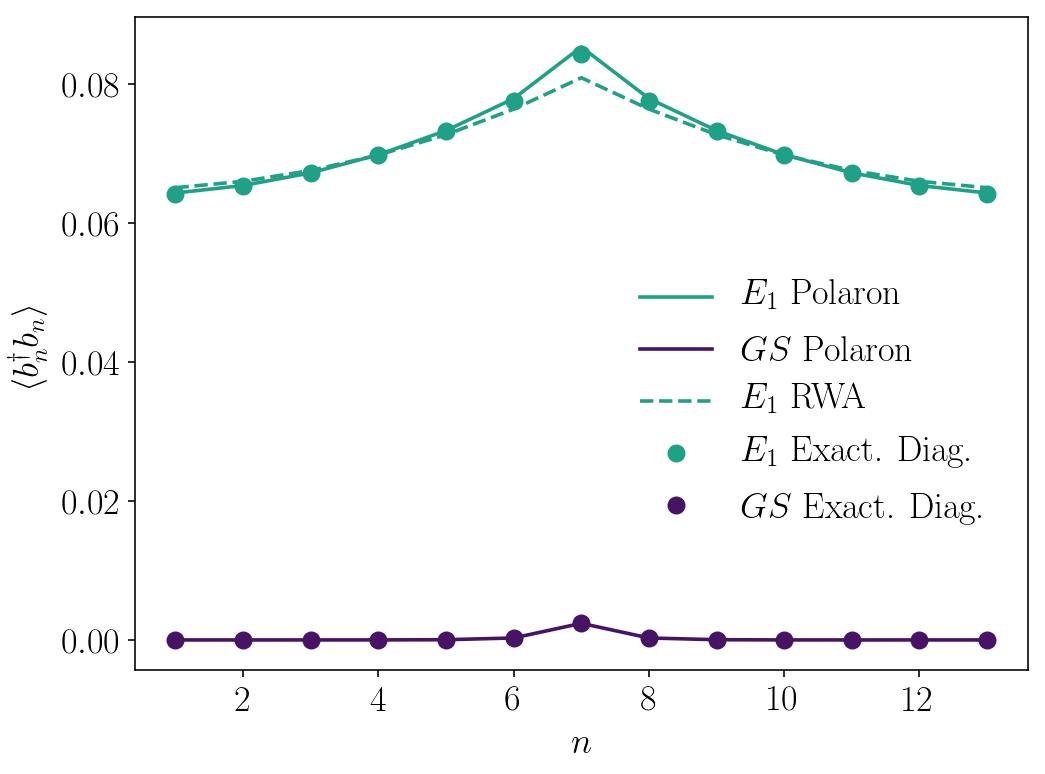

In [14]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 18
sns.set_palette(sns.color_palette("viridis", len(analisis)))

def eff_hamiltonian(deltar, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = deltar / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - deltar / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    f = f_f(deltar, g)
    for k in range(N):
        h3[k + 1, 0] = -2 * deltar * f[k]
        h3[0, k + 1] = -2 * deltar * f[k]
        
    h4 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        for p in range(N):
            h4[p + 1, k + 1] = 2 * deltar * f[k] * f[p]
    
    return h1 + h2 + h3 + h4

def rwa_hamiltonian(delta, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = delta / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - delta / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h3[k + 1, 0] = g / np.sqrt(N)
        h3[0, k + 1] = g / np.sqrt(N)
    
    return h1 + h2 + h3

def sorted_eigsystem(H):
    vals, vects = eig(H)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:,idx]
    
    return Eigensystem(vals, vects)

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)


palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.05
N = 14
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

file_3 = 'data_files/exact_14_2_0,3_0,05.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 7, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)

#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
#plt.xticks(np.arange(40, 62, 2))
plt.legend(loc = [0.55, 0.2], frameon = False)

plt.savefig('figures/1q_exact_005.pdf', bbox_inches = 'tight')
plt.show()

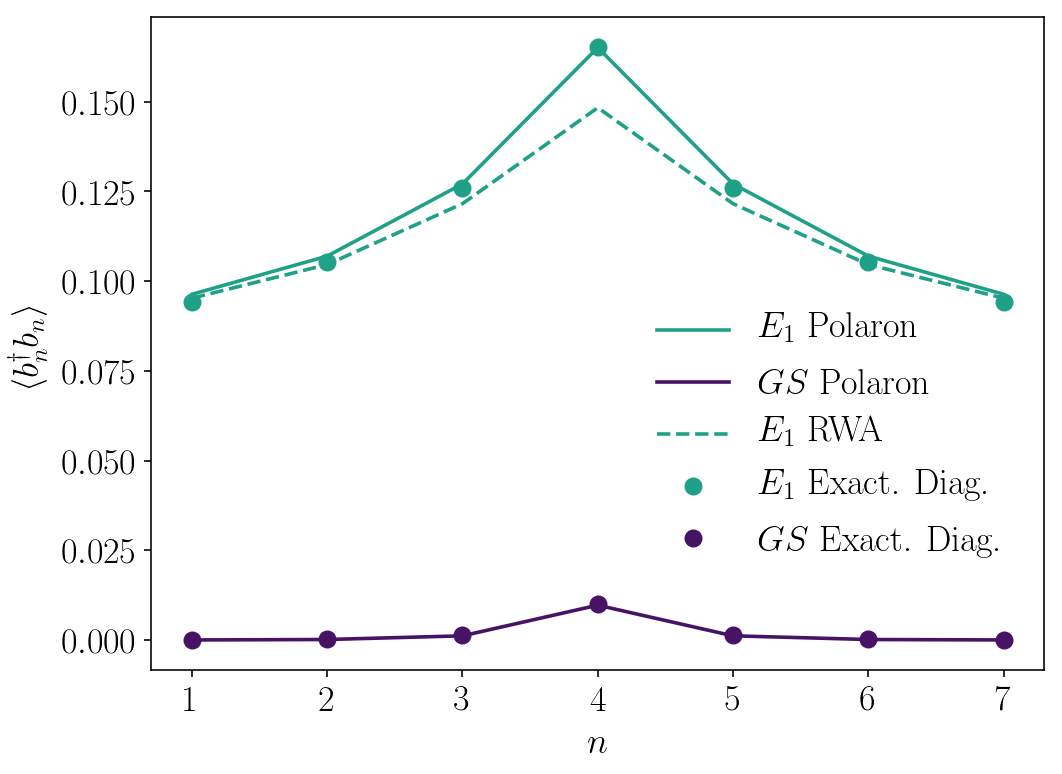

In [15]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 18
sns.set_palette(sns.color_palette("viridis", len(analisis)))

def eff_hamiltonian(deltar, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = deltar / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - deltar / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    f = f_f(deltar, g)
    for k in range(N):
        h3[k + 1, 0] = -2 * deltar * f[k]
        h3[0, k + 1] = -2 * deltar * f[k]
        
    h4 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        for p in range(N):
            h4[p + 1, k + 1] = 2 * deltar * f[k] * f[p]
    
    return h1 + h2 + h3 + h4

def rwa_hamiltonian(delta, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = delta / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - delta / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h3[k + 1, 0] = g / np.sqrt(N)
        h3[0, k + 1] = g / np.sqrt(N)
    
    return h1 + h2 + h3

def sorted_eigsystem(H):
    vals, vects = eig(H)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:,idx]
    
    return Eigensystem(vals, vects)

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)


palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.1
N = 8
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

file_3 = 'data_files/exact_0,3_0,1.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 4, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)

#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
#plt.xticks(np.arange(40, 62, 2))
plt.legend(loc = [0.55, 0.15], frameon = False)

plt.savefig('figures/1q_exact_01.pdf', bbox_inches = 'tight')
plt.show()

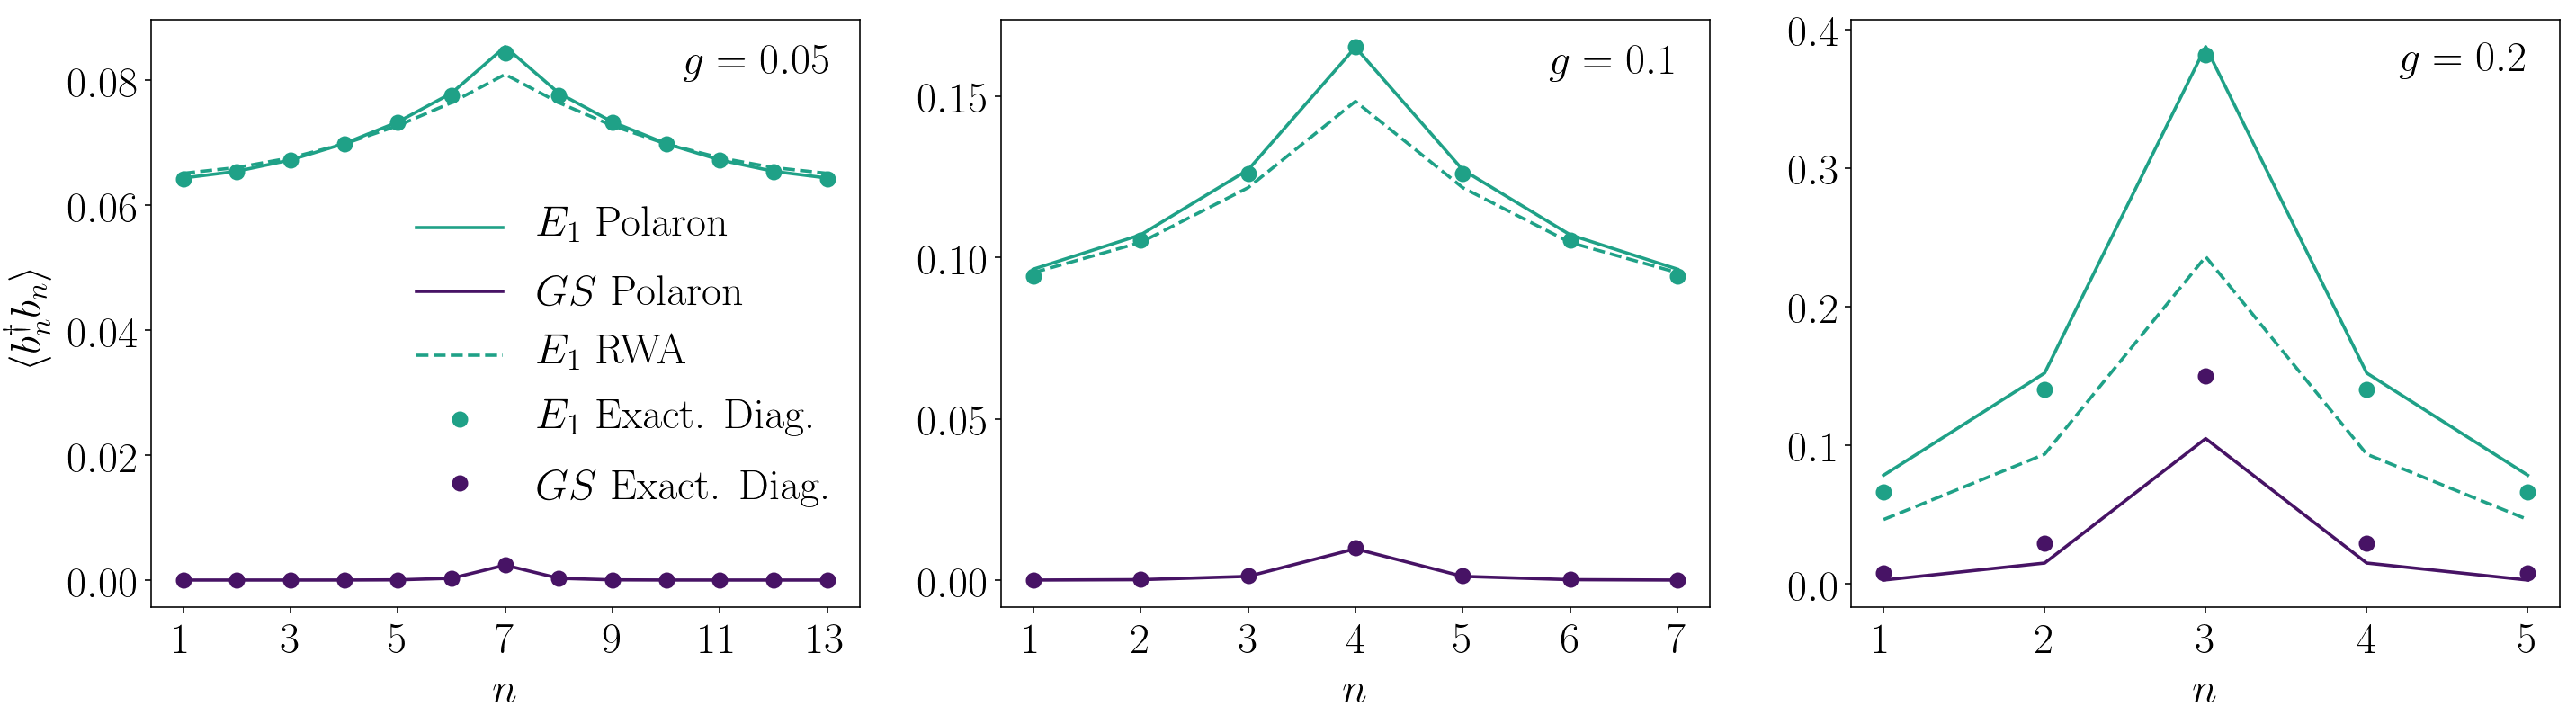

In [16]:
plt.rcParams['figure.figsize'] = 24, 6
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 24

def eff_hamiltonian(deltar, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = deltar / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - deltar / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    f = f_f(deltar, g)
    for k in range(N):
        h3[k + 1, 0] = -2 * deltar * f[k]
        h3[0, k + 1] = -2 * deltar * f[k]
        
    h4 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        for p in range(N):
            h4[p + 1, k + 1] = 2 * deltar * f[k] * f[p]
    
    return h1 + h2 + h3 + h4

def rwa_hamiltonian(delta, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = delta / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - delta / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h3[k + 1, 0] = g / np.sqrt(N)
        h3[0, k + 1] = g / np.sqrt(N)
    
    return h1 + h2 + h3

def sorted_eigsystem(H):
    vals, vects = eig(H)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:,idx]
    
    return Eigensystem(vals, vects)

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)


palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

plt.subplot(1, 3, 1)

delta = 0.3
g = 0.05
N = 14
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

file_3 = 'data_files/exact_14_2_0,3_0,05.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 7, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)

plt.text(10.3, 0.081, r'$g = 0.05$')
#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
plt.xticks(np.arange(1, 14, 2))
plt.legend(loc = [0.35, 0.14], frameon = False)

plt.subplot(1, 3, 2)

delta = 0.3
g = 0.1
N = 8
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

file_3 = 'data_files/exact_0,3_0,1.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 4, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)

plt.text(5.8, 0.157, r'$g = 0.1$')
#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
#plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
#plt.legend(loc = [0.45, 0.13], frameon = False)
plt.xticks(np.arange(1, 8))

plt.subplot(1, 3, 3)

delta = 0.3
g = 0.3
N = 6
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

H_eff = eff_hamiltonian(analisis[delta][g], g)
H_rwa = rwa_hamiltonian(delta, g)

eig_eff = sorted_eigsystem(H_eff)
eig_rwa = sorted_eigsystem(H_rwa)

vals_eff = eig_eff.vals
vects_eff = eig_eff.vects
vals_rwa = eig_rwa.vals
vects_rwa = eig_rwa.vects

vk_eff = vects_eff[:, 0]
vk_rwa = vects_rwa[:, 0]

vn_eff = f_fn(vk_eff[1:])[1:]
vn_rwa = f_fn(vk_rwa[1:])[1:]

f = f_f(analisis[delta][g], g)    
fn = f_fn(f)[1:]

file_3 = 'data_files/exact_6_5_0,3_0,3.txt'
f_3 = open(file_3, 'r')

data_3 = []

n = 0
for row in f_3:
    values = row.split(sep = ' ')
    data_3.append((n + N // 2 - 3, float(values[0]), float(values[1])))
    n += 1

plt.plot([val[0] for val in data_3[1:]], [val[2] for val in data_3[1:]], label = r'$E_1$' + ' Exact. Diag.', marker='o', c = c2, zorder = 0, lw=0, markersize=8)
plt.plot([val[0] for val in data_3[1:]], [val[1] for val in data_3[1:]], label = r'$GS$' + ' Exact. Diag.', marker='o', c = c1, zorder = 0, lw=0, markersize=8)



plt.plot([n for n in range(N)][1:], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn), label = r'$E_1$' + ' Polaron', c = c2)
plt.plot([n for n in range(N)][1:],  np.abs(fn) ** 2, label = r'$GS$' + ' Polaron', c = c1)
plt.plot([n for n in range(N)][1:], np.abs(vn_rwa) ** 2, label = r'$E_1$' + ' RWA', ls = 'dashed', c = c2)

plt.text(4.2, 0.37, r'$g = 0.2$')
#plt.xlim(N // 2 - 10, N // 2 + 10)
plt.xlabel(r'$n$')
#plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
plt.xticks(np.arange(1, 6))
#plt.legend(loc = 'upper left', frameon = False)

plt.savefig('figures/1q_exact_joint.pdf', bbox_inches = 'tight')
plt.show()

In [17]:
N = 100
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

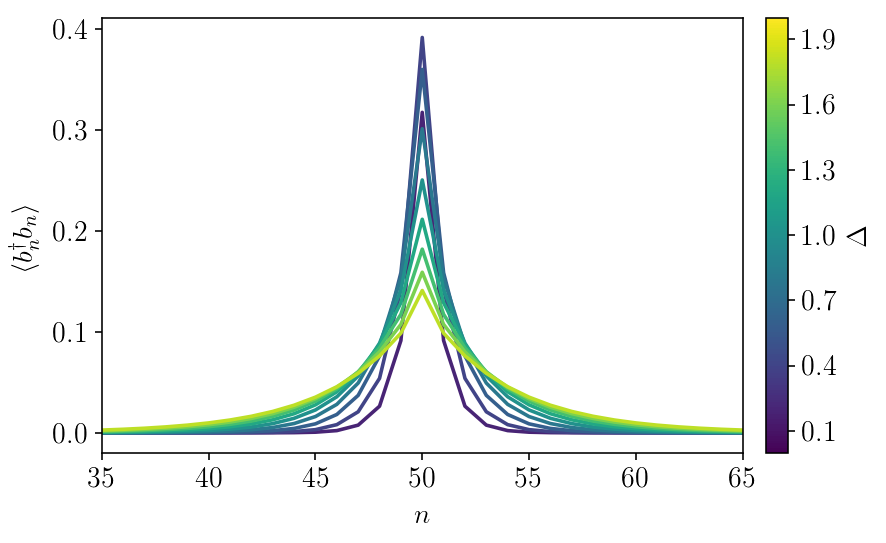

In [18]:
plt.rcParams['figure.figsize'] = 7, 4
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(analisis) // 2))

g = 0.3

gen = [delta for delta, n in zip(eigen_eff.keys(), range(len(eigen_eff.keys()))) if n % 2 == 0]
for delta in gen:
    vals_eff = eigen_eff[delta][g].vals
    vects_eff = eigen_eff[delta][g].vects

    vk_eff = vects_eff[:, 0]
    vn_eff = f_fn(vk_eff[1:])

    f = f_f(analisis[delta][g], g)    
    fn = f_fn(f)

    plt.plot([n for n in range(N)], np.abs(fn) ** 2 + np.abs(vn_eff) ** 2 + 2 * (vk_eff[0] * vn_eff * fn))
    
plt.ylabel(r'$\langle b_n^\dagger b_n \rangle$')
plt.xlabel(r'$n$')
d = 15
plt.xlim(N // 2 - d, N // 2 + d)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)

plt.savefig('figures/1q_bound_nphotons_g=03.pdf', bbox_inches = 'tight')
plt.show()

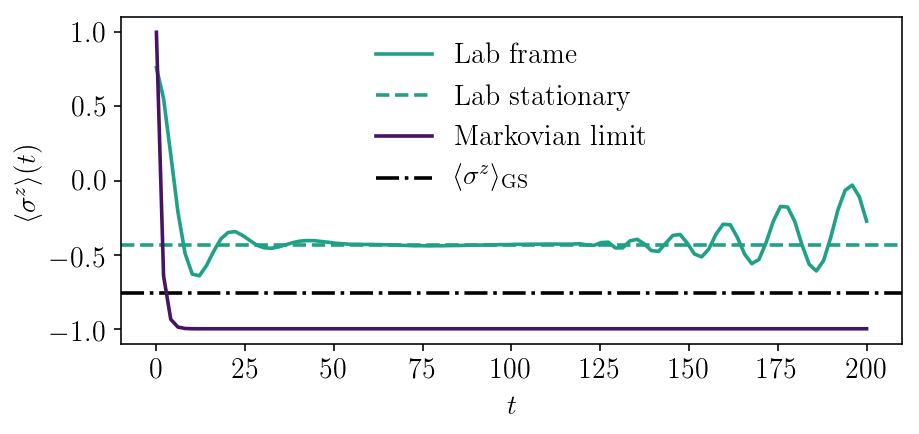

In [19]:
plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(deltas)))

palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.3

PT = PolaronDecay(g, delta)
output, t, psi = PT.evolve(200)

#plt.plot(t, output[:, 0], c = c3, label = 'Polaron frame')
plt.plot(t, output[:, 1], c = c2, label = 'Lab frame')

def f_tau(g, delta):
    deltar = analisis[delta][g]
    k = np.arccos((deltar - 1) / (2 * J))
    
    return  (2* g ** 2 ) * (1 / (2 * J * np.sin(k)))

tau = f_tau(g, delta)



#plt.axhline(PT.overlap() * (PT.overlap_pol() + 1) - 1, ls='dashed', c = c3, zorder = 2, label = 'Polaron stationary')
plt.axhline(PT.overlap() * (PT.overlap_lab() + PT.DeltaR / PT.Delta) - PT.DeltaR / PT.Delta, c = c2, ls = 'dashed', zorder = 1, label = 'Lab stationary')

plt.plot(t, -1 + 2 * np.exp(- tau * t), c = c1, label = 'Markovian limit')
plt.axhline(-PT.DeltaR / PT.Delta, c = 'black', ls = '-.', zorder = 0, label = r'$\langle \sigma^z \rangle_{\rm GS}$')

plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma^z \rangle (t)$')
plt.legend(frameon = False)

plt.savefig('figures/1q_evol_g=03.pdf', bbox_inches = 'tight')
plt.show()

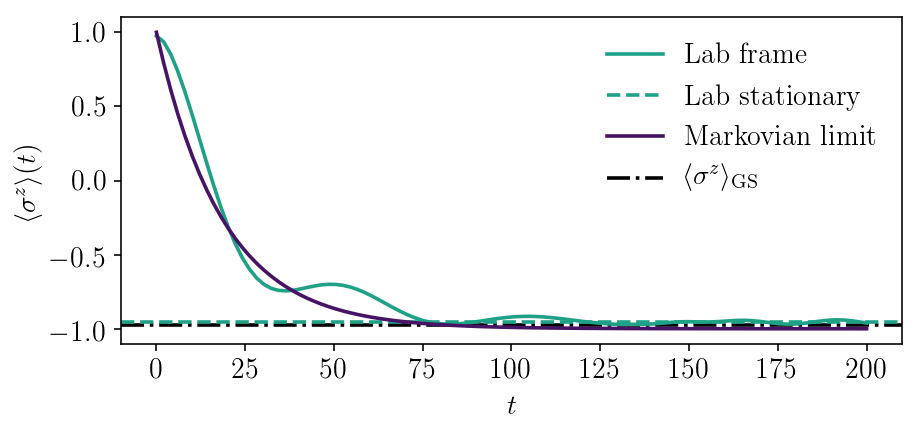

In [20]:
plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 14
sns.set_palette(sns.color_palette("viridis", len(deltas)))

palette = itertools.cycle(sns.color_palette("viridis", 20))
c1 = next(palette)
for n in range(10):
    next(palette)
    
c2 = next(palette)

delta = 0.3
g = 0.1

PT = PolaronDecay(g, delta)
output, t, psi = PT.evolve(200)

#plt.plot(t, output[:, 0], c = c3, label = 'Polaron frame')
plt.plot(t, output[:, 1], c = c2, label = 'Lab frame')

def f_tau(g, delta):
    deltar = analisis[delta][g]
    k = np.arccos((deltar - 1) / (2 * J))
    
    return  (2* g ** 2 ) * (1 / (2 * J * np.sin(k)))

tau = f_tau(g, delta)

#plt.plot(t, -1 + 2 * np.exp(- tau * t), c = c1, label = 'Markovian limit')

#plt.axhline(PT.overlap() * (PT.overlap_pol() + 1) - 1, ls='dashed', c = c3, zorder = 2, label = 'Polaron stationary')
plt.axhline(PT.overlap() * (PT.overlap_lab() + PT.DeltaR / PT.Delta) - PT.DeltaR / PT.Delta, c = c2, ls = 'dashed', zorder = 1, label = 'Lab stationary')
#plt.axhline(-PT.DeltaR / PT.Delta, c = c2, ls = '-.', zorder = 0, label = 'Lab stationary w/o bound states')

plt.plot(t, -1 + 2 * np.exp(- tau * t), c = c1, label = 'Markovian limit')
plt.axhline(-PT.DeltaR / PT.Delta, c = 'black', ls = '-.', zorder = 0, label = r'$\langle \sigma^z \rangle_{\rm GS}$')



plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma^z \rangle (t)$')
plt.legend(frameon = False)

plt.savefig('figures/1q_evol_g=01.pdf', bbox_inches = 'tight')
plt.show()